In [ ]:
!nvidia-smi

Sat Dec 12 07:38:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |  11707MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install segmentation_models_pytorch

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob

import torch
from torch.nn import Sigmoid
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

from IPython.display import clear_output

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import albumentations as A
import segmentation_models_pytorch as smp
scaler = torch.cuda.amp.GradScaler()


## Download Data

In [ ]:
# !pip install -q kaggle
# from google.colab import files
# files.upload()

In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json /root/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d iafoss/hubmap-256x256

# !mkdir /content/data/
# !unzip /content/hubmap-256x256.zip -d /content/data/

## Config


In [ ]:
## augmentation ######################################################################
#flip
def do_random_flip_transpose(image, mask):
    mask = mask.squeeze()
    if np.random.rand()>0.5:
        image = cv2.flip(image,0)
        mask = cv2.flip(mask,0)
    if np.random.rand()>0.5:
        image = cv2.flip(image,1)
        mask = cv2.flip(mask,1)
    if np.random.rand()>0.5:
        image = image.transpose(1,0,2)
        mask = mask.transpose(1,0)

    image = np.ascontiguousarray(image)
    mask = np.ascontiguousarray(mask)
    return image, mask

#geometric
def do_random_crop(image, mask, size):
    height, width = image.shape[:2]
    x = np.random.choice(abs(width -size))
    y = np.random.choice(abs(height-size))
    image = image[y:y+size,x:x+size].squeeze()
    mask  = mask[y:y+size,x:x+size].squeeze()

    return image, mask

def do_random_scale_crop(image, mask, size, mag):
    height, width = image.shape[:2]

    s = 1 + np.random.uniform(-1, 1)*mag
    s =  int(s*size)
    if s != width and s != height:
      x = np.random.choice(abs(width -s))
      y = np.random.choice(abs(height-s))
    else:
      x, y = 0, 0
    image = image[y:y+s,x:x+s]
    mask  = mask[y:y+s,x:x+s]
    if s!=size:
        image = cv2.resize(image, dsize=(size,size), interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask, dsize=(size,size), interpolation=cv2.INTER_LINEAR)
    return image, mask

def do_random_rotate_crop(image, mask, size, mag=30 ):
    angle = 1+np.random.uniform(-1, 1)*mag

    height, width = image.shape[:2]
    dst = np.array([
        [0,0],[size,size], [size,0], [0,size],
    ])
    PI = 3.14159265359
    c = np.cos(angle/180*2*PI)
    s = np.sin(angle/180*2*PI)
    src = (dst-size//2)@np.array([[c, -s],[s, c]]).T
    src[:,0] -= src[:,0].min()
    src[:,1] -= src[:,1].min()

    src[:,0] = src[:,0] + np.random.uniform(0,width -src[:,0].max())
    src[:,1] = src[:,1] + np.random.uniform(0,height-src[:,1].max())

    if 0: #debug
        def to_int(f):
            return (int(f[0]),int(f[1]))

        cv2.line(image, to_int(src[0]), to_int(src[1]), (0,0,1), 16)
        cv2.line(image, to_int(src[1]), to_int(src[2]), (0,0,1), 16)
        cv2.line(image, to_int(src[2]), to_int(src[3]), (0,0,1), 16)
        cv2.line(image, to_int(src[3]), to_int(src[0]), (0,0,1), 16)
        image_show_norm('image', image, min=0, max=1)
        cv2.waitKey(1)


    transform = cv2.getAffineTransform(src[:3].astype(np.float32), dst[:3].astype(np.float32))
    image = cv2.warpAffine( image, transform, (size, size), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=(0,0,0)).squeeze()
    mask  = cv2.warpAffine( mask, transform, (size, size), flags=cv2.INTER_LINEAR,
                                 borderMode=cv2.BORDER_CONSTANT, borderValue=0).squeeze()
    return image, mask

#warp/elastic deform ...
#<todo>

#noise
def do_random_noise(image, mask, mag=0.1):
    height, width = image.shape[:2]
    noise = np.random.uniform(-1,1, (height, width,1))*mag
    image = image + noise
    image = np.clip(image,0,1)
    return image, mask


#intensity
def do_random_contast(image, mask, mag=0.3):
    alpha = 1 + np.random.uniform(-1,1)*mag
    image = image * alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_gain(image, mask, mag=0.3):
    alpha = 1 + np.random.uniform(-1,1)*mag
    image = image ** alpha
    image = np.clip(image,0,1)
    return image, mask

def do_random_hsv(image, mask, mag=[0.15,0.25,0.25]):
    image = (image*255).astype(np.uint8)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    h = hsv[:, :, 0].astype(np.float32)  # hue
    s = hsv[:, :, 1].astype(np.float32)  # saturation
    v = hsv[:, :, 2].astype(np.float32)  # value
    h = (h*(1 + np.random.uniform(-1,1)*mag[0]))%180
    s =  s*(1 + np.random.uniform(-1,1)*mag[1])
    v =  v*(1 + np.random.uniform(-1,1)*mag[2])

    hsv[:, :, 0] = np.clip(h,0,180).astype(np.uint8)
    hsv[:, :, 1] = np.clip(s,0,255).astype(np.uint8)
    hsv[:, :, 2] = np.clip(v,0,255).astype(np.uint8)
    image = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    image = image.astype(np.float32)/255
    return image, mask



#shuffle block, etc
#<todo>


# post process ---
# https://stackoverflow.com/questions/42798659/how-to-remove-small-connected-objects-using-opencv/42812226

# min_radius = 50
# min_area = 7853
#
#
def filter_small(mask, min_size):

    m = (mask*255).astype(np.uint8)

    num_comp, comp, stat, centroid = cv2.connectedComponentsWithStats(m, connectivity=8)
    if num_comp==1: return mask

    filtered = np.zeros(comp.shape,dtype=np.uint8)
    area = stat[:, -1]
    for i in range(1, num_comp):
        if area[i] >= min_size:
            filtered[comp == i] = 255
    return filtered

# ============================================
def train_augment(image, mask):
    image_size = 256 # Crop size

    for fn in np.random.choice([
        lambda image, mask : do_random_rotate_crop(image, mask, size=image_size, mag=45),
        lambda image, mask : do_random_scale_crop(image, mask, size=image_size, mag=0.075),
        # lambda image, mask : do_random_crop(image, mask, size=image_size),
    ],1): image, mask = fn(image, mask)

    for fn in np.random.choice([
        lambda image, mask : (image, mask),
        lambda image, mask : do_random_contast(image, mask, mag=0.8),
        lambda image, mask : do_random_gain(image, mask, mag=0.9),
        #lambda image, mask : do_random_hsv(image, mask, mag=[0.1, 0.2, 0]),
        lambda image, mask : do_random_noise(image, mask, mag=0.1),
    ],2): image, mask =  fn(image, mask)

    image, mask = do_random_hsv(image, mask, mag=[0.1, 0.2, 0])
    image, mask = do_random_flip_transpose(image, mask)

    return image, mask

In [ ]:
x = np.zeros((256,256,1))
x.squeeze().shape

(256, 256)

In [ ]:
import numpy as np
class Config:
    seed = 55
    images_path = '/content/data/train'
    masks_path = '/content/data/masks'
    img_size = 256
    pretrained_model_path = None
    train_logs_path = None
    test_csv_path = ''
    
def seed_everything(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
       
config = Config()
seed_everything(config.seed)

import os
import pandas as pd
import cv2

mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

def img2tensor(img, dtype:np.dtype=np.float32):
  if img.ndim==2 : img = np.expand_dims(img, 2)
  img = np.transpose(img, (2, 0, 1))
  return torch.from_numpy(img.astype(dtype, copy=False))

def get_augmentation(phase: str='train'):
  if phase == 'train':
    list_transform = [
      A.HorizontalFlip(),
      A.OneOf([
        A.RandomContrast(),
        A.RandomGamma(),
        A.RandomBrightness()
      ], p=0.3),
      A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120*0.05, alpha_affine=120*0.03),
        A.GridDistortion(),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5)
      ], p=0.3),
      A.ShiftScaleRotate(p=0.2),
      A.Resize(config.img_size, config.img_size, always_apply=True),
    ]
  else: 
    list_transform = [
      A.Resize(config.img_size, config.img_size)
    ]
  return A.Compose(list_transform)

class HuBMAPDataset(Dataset):
  def __init__(self, ids, phase):
    self.ids = ids
    self.augmentations_albu = get_augmentation(phase)
    self.aug_type = 'cv2'  # Albu, cv2

  def __getitem__(self, idx):
    name = self.ids[idx]
    img = cv2.imread(f'{config.images_path}/{name}').astype('float32')
    img /= 255.
    mask = cv2.imread(f'{config.masks_path}/{name}')[:, :, 0:1]
    if self.aug_type == 'albu':
        augmented = self.augmentations_albu(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
    elif self.aug_type == 'cv2':
        img, mask = train_augment(img,mask)
        mask = mask.reshape(mask.shape[0], mask.shape[1], 1)
    img = img.transpose(2, 0, 1).astype('float32')
    mask = mask.transpose(2, 0, 1).astype('float32')
    return img, mask

  def __len__(self):
    return len(self.ids)


def get_dataloader(phase: str = 'train', batch_size: int = 8, num_workers: int = 6, val_size: float = 0.2, fold: int = 0 ): 
  ids = os.listdir(config.images_path)
  train_data = pd.DataFrame(ids, columns=['ids'])
  skf = KFold(n_splits=7, random_state=config.seed, shuffle=True)
  for i, (train_index, val_index) in enumerate(skf.split(train_data, train_data)):
    train_data.loc[val_index, 'fold'] = i
    train_df = train_data.loc[train_data['fold'] != fold].reset_index(drop=True)
    val_df = train_data.loc[train_data['fold'] == fold].reset_index(drop=True)
    ids = train_df['ids'].tolist() if phase == 'train' else val_df['ids'].tolist()
    image_dataset = HuBMAPDataset(ids, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers= num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor, 
                     threshold: float=0.5,
                     eps: float=1e-9) -> np.ndarray:
  scores = []
  num = probabilities.shape[0]
  predictions = (probabilities >= threshold).float()
  assert(predictions.shape == truth.shape)
  for i in range(num):
    prediction = predictions[i]
    truth_ = truth[i]
    intersection = 2.0 * (truth_*prediction).sum()
    union = truth_.sum() + prediction.sum()
    if truth_.sum() == 0 and prediction.sum() == 0:
      scores.append(1.0)
    else:
      scores.append((intersection+eps) / union)
  return np.mean(scores)

class Meter:
  def __init__(self, threshold: float=0.5):
    self.threshold = threshold
    self.dice_scores = []
  
  def update(self, logits: torch.Tensor, targets: torch.Tensor):
    probs = F.sigmoid(logits.to('cuda'))
    probs = probs.cpu()
    dice = dice_coef_metric(probs, targets, self.threshold)
    self.dice_scores.append(dice)
  
  def get_metrics(self) -> np.ndarray:
    dice = np.mean(self.dice_scores)
    return dice

class DiceLoss(nn.Module):
  def __init__(self, eps=1e-9):
    super(DiceLoss, self).__init__()
    self.eps = eps

  def forward(self, logits, targets):
    num = targets.size(0)
    probability = torch.sigmoid(logits)
    probability = probability.view(num, -1)
    targets = targets.view(num, -1)
    assert(probability.shape == targets.shape)
    intersection = 2.0*(probability*targets).sum()
    union = probability.sum() + targets.sum()
    dice_score = (intersection +self.eps) / union
    return 1.0 - dice_score

class Lovasz_hinge_loss(nn.Module):
  def __init__(self):
    super(Lovasz_hinge_loss, self).__init__()

  def forward(self, logits, labels, per_image=False, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


import time
from tqdm import tqdm
import os
class Trainer:
  def __init__(self,
               model: nn.Module,
               metric: nn.Module,
               lr: float,
               accumulation_steps: int,
               batch_size: int,
               num_epochs: int,
               verbose: bool=True,
               n_fold: int = 0):
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('device: ', self.device)
    self.verbose = verbose
    self.model = model
    self.model = self.model.to(self.device)
    self.metric = metric
    self.optimizer = Adam(self.model.parameters(), lr=lr)
    self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', patience=3, verbose=True)
    self.accumulation_steps = accumulation_steps // batch_size
    self.phases = ['train', 'val']
    self.num_epochs = num_epochs
    self.dataLoaders = {
        phase: get_dataloader(phase=phase, batch_size=batch_size, num_workers=4) for phase in self.phases
    }
    self.best_loss = float('inf')
    self.losses = {phase: [] for phase in self.phases}
    self.dice_score = {phase: [] for phase in self.phases}

  def compute_loss_and_output(self, images, masks):
    images = images.to(self.device)
    masks = masks.to(self.device)
    logits = self.model(images)
    loss = self.metric(logits, masks)
    return loss, logits

  def train_epoch(self, epoch, phase):
    print(f'{phase} epoch: {epoch}')
    self.model.train() if phase == 'train' else self.model.eval()
    meter = Meter()
    dataloader = self.dataLoaders[phase]
    total_batches = len(dataloader)
    running_loss = 0.0
    self.optimizer.zero_grad()
    tbar = tqdm(dataloader)

    for i, (images, targets) in enumerate(tbar):
      with torch.cuda.amp.autocast(): 
        loss, logits = self.compute_loss_and_output(images, targets)
      loss = loss / self.accumulation_steps
      if phase == 'train':
        scaler.scale(loss).backward()
        if (i+1) % self.accumulation_steps == 0:
          scaler.step(self.optimizer)
          scaler.update()
          self.optimizer.zero_grad()
      running_loss += loss.item()
      meter.update(logits.detach().cpu(), targets.detach().cpu())

      # Record loss
      tbar.set_description("Train loss: %.9f, learning rate: %.10f" % (
            loss, self.optimizer.param_groups[-1]['lr']))
        
    epoch_loss = (running_loss * self.accumulation_steps) / total_batches
    epoch_dice = meter.get_metrics()
    self.losses[phase].append(epoch_loss)
    self.dice_score[phase].append(epoch_dice)
    return epoch_loss

  def train(self):
    for epoch in range(self.num_epochs):
      self.train_epoch(epoch, 'train')
      with torch.no_grad():
        val_loss = self.train_epoch(epoch,'val')
        self.scheduler.step(val_loss)
      if self.verbose:
        self.plot_history()
      if val_loss < self.best_loss:
        self.best_loss = val_loss
        torch.save(self.model.state_dict(), 'best_model.pth')
        os.system('cp best_model.pt /content/drive/MyDrive')
        print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
    self.save_history()
    
  def plot_history(self):
    data = [self.losses, self.dice_score]
    colors = ['deepskyblue', 'crimson']
    labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_score['train'][-1]}
            val dice score {self.dice_score['val'][-1]} 
            """, 
    ]

    clear_output(True)
    with plt.style.context("seaborn-dark-palette"):
      fig, axes = plt.subplots(2, 1, figsize=(8, 10))
      for i, ax in enumerate(axes):
        ax.plot(data[i]['val'], c=colors[0], label="val")
        ax.plot(data[i]['train'], c=colors[-1], label="train")
        ax.set_title(labels[i])
        ax.legend(loc="upper right")
      plt.tight_layout()
      plt.show()

  def save_history(self):
    torch.save(self.model.state_dict(), f"last_epoch_model.pth")
    logs_ = [self.losses, self.dice_score]
    log_names_ = ["_loss", "_dice"]
    logs = [logs_[i][key] for i in list(range(len(logs_))) for key in logs_[i]]
    log_names = [key+log_names_[i] for i in list(range(len(logs_))) for key in logs_[i]]
    pd.DataFrame(dict(zip(log_names, logs))).to_csv("train_log.csv", index=False)

  def load_pretrained_model(self, model_path):
    self.model.load_state_dict(torch.load(model_path))
    print('Pretrained model loaded.')

## Model Building


In [ ]:
def Unet(encoder_backbone='resnet18', encoder_weights='imagenet'):
    return smp.Unet(encoder_name=encoder_backbone,
                    encoder_weights=encoder_weights,
                    in_channels=3,
                    classes=1)

## Model Training

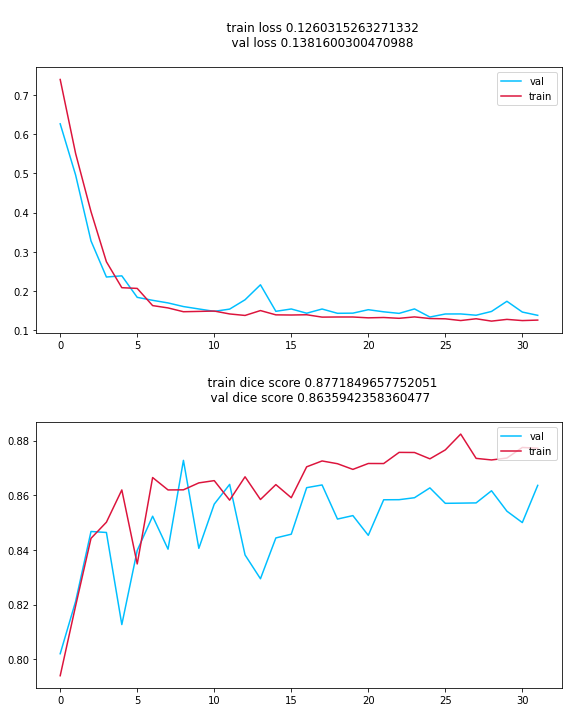





  0%|          | 0/50 [00:00<?, ?it/s]

train epoch: 32


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")




Train loss: 0.154262841, learning rate: 0.0000020000:   0%|          | 0/50 [00:03<?, ?it/s]



Train loss: 0.154262841, learning rate: 0.0000020000:   2%|▏         | 1/50 [00:03<02:53,  3.55s/it]



Train loss: 0.180186510, learning rate: 0.0000020000:   2%|▏         | 1/50 [00:04<02:53,  3.55s/it]



Train loss: 0.180186510, learning rate: 0.0000020000:   4%|▍         | 2/50 [00:04<02:11,  2.73s/it]



Train loss: 0.099339008, learning rate: 0.0000020000:   4%|▍         | 2/50 [00:05<02:11,  2.73s/it]



Train loss: 0.099339008, learning rate: 0.0000020000:   6%|▌         | 3/50 [00:05<01:41,  2.17s/it]



Train loss: 0.087948263, learning rate: 0.0000020000:   6%|▌         | 3/50 [00:06<01:41,  2.17s/it]



Train loss: 0.087948263, learning rate: 0.000002

KeyboardInterrupt: ignored

In [ ]:
model = Unet('resnet34')
# model_path = '/content/best_model.pth'
# model.load_state_dict(torch.load(model_path))
trainer = Trainer(model=model, 
                  metric=DiceLoss(), 
                  lr=2e-4, 
                  accumulation_steps=64, 
                  batch_size=64,
                  num_epochs=50,
                  n_fold=0)
trainer.train()

## Inference

In [ ]:
test_model = Unet('resnet34')
model_path = '/content/best_model.pth'
test_model.load_state_dict(torch.load(model_path))
test_model.to('cuda')

# Inference
img_id = '1e2425f28_624.png'
img_path = ('/content/data/train/' + img_id)
mask_path = ('/content/data/masks/' + img_id)
img = cv2.imread(img_path)
plt.imshow(img, cmap='gray')
plt.show()

# Feed to NN
img = img.transpose((2,0,1))
img = torch.tensor(np.expand_dims(img, axis=0), dtype=torch.float).to('cuda')
out = test_model(img)
sigmoid = Sigmoid()
out = F.sigmoid(out)
out = np.array(out.detach().cpu()) # Detach remove all saved grad
out = out > 0.4
plt.imshow(out[0][0], cmap='gray')
plt.show()

im = cv2.imread(mask_path).transpose(2,0,1)[0]
plt.imshow(im, cmap='gray')
plt.show()